#1. UTILS

In [ ]:
!pip install ktrain
!pip install unidecode
!pip install afinn
!pip install geopandas
!pip install transformers
!pip install pysal==2.3.0 # last version, 2.4.0 cannot be installed (try later)

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import random
import os
import re
import string
import nltk
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

nltk.download("stopwords")
from nltk.corpus import stopwords
import re

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models.fasttext import FastText

nltk.download('punkt')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import unidecode
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'

#Display every call in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Lexicons
from textblob import TextBlob
from afinn import Afinn
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

nltk.download('vader_lexicon', 'wordnet')

from sklearn.metrics import classification_report

# Bert
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

[nltk_data] Downloading package vader_lexicon to wordnet...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Spatial weights matrix
from libpysal.weights.contiguity import Queen
from pysal.model import spreg
from pysal.lib import weights
# from pysal.explore import esda

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# global and local autorcorrelation
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
phd_path = 'gdrive/My Drive'
path = os.path.join(phd_path, 'Perceptia_fiscalitatii')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import nltk
# nltk.download('wordnet')
# # import these modules
# from nltk.stem import WordNetLemmatizer
  
# lemmatizer = WordNetLemmatizer()
  
# print("rocks :", lemmatizer.lemmatize("rocks"))

In [16]:
# Text preprocessing
stopwords = nltk.corpus.stopwords.words('english')
# wordnet_lemmatizer = WordNetLemmatizer()
punctuation_signs= [c for c in string.punctuation] + ['``', "''", '...', '..']

# Clean the text
def clean_text(raw_string, remove_emojies=True):
  # replace new line
  cleaned_string = re.sub('\n', ' ', raw_string)
  # remove emoji
  if remove_emojies:
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                # "^a-zA-Z"
                                "]+", flags=re.UNICODE)
    cleaned_string = emoji_pattern.sub(r'', cleaned_string)
  # lower all letters
  cleaned_string = cleaned_string.lower()
  # remove special characters and numbers
  cleaned_string = re.sub("-|.|;|:", " ", cleaned_string, re.I)
  cleaned_string = re.sub("[^a-z ]", " ", cleaned_string, re.I)
  # remove multiple spaces
  cleaned_string = re.sub(' +', ' ', cleaned_string)
  # tokenize strings
  cleaned_string = nltk.word_tokenize(cleaned_string)
  # remove stopwords and punctuation signs
  cleaned_string = [word.strip() for word in cleaned_string if word not in stopwords]
  cleaned_string = [word.strip() for word in cleaned_string if word not in punctuation_signs]
  # lemmatize the words
  # cleaned_string = [wordnet_lemmatizer.lemmatize(word) for word in cleaned_string]

  return cleaned_string


def create_bigrams(row):
  ngrams = nltk.ngrams(row, 2)
  ngram_list = []
  for item in ngrams:
    ngram_list.append(item[0]+' '+item[1])
  return ngram_list


def create_trigrams(row):
  ngrams = nltk.ngrams(row, 3)
  ngram_list = []
  for item in ngrams:
    ngram_list.append(item[0]+' '+item[1] + ' '+ item[2])

  return ngram_list

<center><h1>Evaluating sustainability goals at European level from spatial perspective using peoples` perception and sentiment analysis</h1></center>

## Aim
>  Our aim is to evaluate the sustainability goals at European level from a spatial perspective using the taxpayers' perception and sentiment analysis.
We measured people's trust in their national public institutions, their personal values regarding fair principles like transparency, clearer laws, predictability, efficiency in public spending, public services quality and social welfare creation and we analyzed these factors against EUs sustainability goals. We start from the premise that the individuals’ internal and external motivations are materialized in feelings about a subject that leads to a certain type of action. Whether taxpayers trust in State and the way it spends public money is best revealed in their free speech language when expressing their opinion about it. Considering people`s opinion on public measures helps the State achieve its target of sustainable and interactive governance.

## Data
We use the **[Confidence in EU institutions](https://ec.europa.eu/eurostat/cache/metadata/en/sdg_16_60_esmsip2.htm)** sourced from the Eurostat database as the official susteinabiliy measure from the social perpective and measure it against the people's trust as proxied by the answers to a questionnaire:
*	Q1. How do you evaluate your level of trust in the European institutions?
*	Q2. What do you think of the European institutions?
*	Q3. In your opinion how important are these aspects for the European institutions? [Transparency] [Value for money][Economical (Efficiency)][Trust][Social welfare] [Workplace creation] [Socio-economic development][Stability (Political)][Predictability]
*	Q4. Which public services are most important to you? [Healthcare] [Education] [Social assistance] [Unemployment] [Infrastructure] [Public investments] [Public order] [Emergency services] [Justice] [Public administration]
*	Q5. What is your country of residence?
*	Q6. What gender are you?
*	Q7. What age are you?
*	Q8. How do you evaluate your level of trust in the national institutions?
*	Q9. What do you think of the national institutions?
*	Q10. In your opinion how important are these aspects for the national institutions? [Transparency] [Value for money][Economical (Efficiency)][Trust][Social welfare] [Workplace creation] [Socio-economic development][Stability (Political)][Predictability]


The Questionnaire is formulated as:
<table align='center' style='font-size:16px'><tr><th> </th>
    <th> Seedling </th>
    <th> Vegetative </th>
    <th> Budding </th>
    <th> Flowering </th>
    <th> Ripening </th>
 </tr>
<tr align="center">
    <td><b>Stages</b></td>
    <td>Roots Development</td>
    <td>Stems Growth</td>
    <td>Plants Formation</td>
    <td>Flowers/Fruits</td>
    <td>More Nutrition</td>
</tr>
<tr align='center'>
    <td><b>Sector / Country</b></td>
    <td>Lack of good<br>of Data</td>
    <td>Building a data<br> culuture</td>
    <td>Supporting the Startups<br> with Talent, Fundings</td>
    <td>Major Investments<br>in AI Initiatives</td>
    <td>Qualified Professionals<br>Better Jobs<br>Education Degrees</td>
</tr>
<tr align='center'>
    <td><b>Organizations</b></td>
    <td>Establishing the need<br>of Data / AI</td>
    <td>Focus on data <br>procurement</td>
    <td>Minimal analysis,<br>and basic modelling</td>
    <td>Use of data, <br>predictive modelling,<br>and machine learning</td>
    <td>Models in Production <br> with Greater ROI</td>
</tr>
</table>
</div>

## Methodology:
1. [Sentiment analysis of the open-ended questions](#sa) 
2. [Exploratory Spatial Data Analysis](#esda)
3. [Spatial model specification search](#smss)
4. [Interpreting the model’s results](#imr)

<a name="sa"></a>
# 1. Sentiment analysis of the open-ended questions

In [9]:
VARIABLES_OF_INTEREST = [
       'What do you think of your national Tax Sistem?',
       'If you were the Minister of Public Finance, what would you change about the Tax System?',
       'In your opinion, how important are these aspects for a Tax System? [Transparency ]',
       'In your opinion, how important are these aspects for a Tax System? [Value for money]',
       'In your opinion, how important are these aspects for a Tax System? [Economical (Efficiency)]',
       'In your opinion, how important are these aspects for a Tax System? [Trust]',
       'In your opinion, how important are these aspects for a Tax System? [Social welfare]',
       'In your opinion, how important are these aspects for a Tax System? [Workplace creation]',
       'In your opinion, how important are these aspects for a Tax System? [Socio-economic development]',
       'In your opinion, how important are these aspects for a Tax System? [Stability (Political)]',
       'In your opinion, how important are these aspects for a Tax System? [Predictability]',
       'Which public services are most important to you? [Healthcare ]',
       'Which public services are most important to you? [Education]',
       'Which public services are most important to you? [Social assistance]',
       'Which public services are most important to you? [Unemployment]',
       'Which public services are most important to you? [Infrastructure]',
       'Which public services are most important to you? [Public investments]',
       'Which public services are most important to you? [Public order]',
       'Which public services are most important to you? [Emergency services]',
       'Which public services are most important to you? [Justice]',
       'Which public services are most important to you? [Public administration]',
       'Country of residence:', 
       'Confidence in EU institutions']
TEXT_COLUMN = 'If you were the Minister of Public Finance, what would you change about the Tax System?'
DEPENDENT_VARIABLE = 'Confidence in EU institutions'

In [10]:
df = pd.read_csv(os.path.join(path, 'data', 'Taxpayer perception on the Fiscal System 367 responses 03.11.2021.csv'))
df = df[VARIABLES_OF_INTEREST]
df.rename(columns={'Country of residence:': 'Country of residence'}, inplace=True)
df.head(3) # Original dataset
df.shape

,What do you think of your national Tax Sistem?,"If you were the Minister of Public Finance, what would you change about the Tax System?","In your opinion, how important are these aspects for a Tax System? [Transparency ]","In your opinion, how important are these aspects for a Tax System? [Value for money]","In your opinion, how important are these aspects for a Tax System? [Economical (Efficiency)]","In your opinion, how important are these aspects for a Tax System? [Trust]","In your opinion, how important are these aspects for a Tax System? [Social welfare]","In your opinion, how important are these aspects for a Tax System? [Workplace creation]","In your opinion, how important are these aspects for a Tax System? [Socio-economic development]","In your opinion, how important are these aspects for a Tax System? [Stability (Political)]",...,Which public services are most important to you? [Social assistance],Which public services are most important to you? [Unemployment],Which public services are most important to you? [Infrastructure],Which public services are most important to you? [Public investments],Which public services are most important to you? [Public order],Which public services are most important to you? [Emergency services],Which public services are most important to you? [Justice],Which public services are most important to you? [Public administration],Country of residence,Confidence in EU institutions
0,4.0,I would emphasize a digitalization of tax admi...,4.0,4.0,3.0,4.0,3.0,4.0,4.0,5.0,...,3.0,3.0,4.0,2.0,4.0,4.0,4.0,3.0,The Czech Republic,50.0
1,8.0,Nothing special,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,...,3.0,1.0,4.0,3.0,4.0,4.0,4.0,4.0,Serbia,46.0
2,2.0,Almost everything,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,Bosnia and Herzegovina,44.0


(552, 23)

In [11]:
# Create a preprocessed tokens and a word count coulmns
df[TEXT_COLUMN] = df[TEXT_COLUMN].fillna("") #treat missing values
df[f'{TEXT_COLUMN} Tokens'] = df[TEXT_COLUMN].apply(lambda x: clean_text(x))
df[f'{TEXT_COLUMN} Word Count'] = df[f'{TEXT_COLUMN} Tokens'].apply(len)

In [15]:
df = df.loc[df[f'{TEXT_COLUMN} Word Count']>1] # remove all empty or one word rows
df[f'{TEXT_COLUMN} Bigrams'] = df[f'{TEXT_COLUMN} Tokens'] .apply(lambda row: create_bigrams(row))
df[f'{TEXT_COLUMN} Trigrams'] = df[f'{TEXT_COLUMN} Tokens'] .apply(lambda row: create_trigrams(row))
df.shape 
df.head(3) # Preprocessed dataset

(281, 27)

,What do you think of your national Tax Sistem?,"If you were the Minister of Public Finance, what would you change about the Tax System?","In your opinion, how important are these aspects for a Tax System? [Transparency ]","In your opinion, how important are these aspects for a Tax System? [Value for money]","In your opinion, how important are these aspects for a Tax System? [Economical (Efficiency)]","In your opinion, how important are these aspects for a Tax System? [Trust]","In your opinion, how important are these aspects for a Tax System? [Social welfare]","In your opinion, how important are these aspects for a Tax System? [Workplace creation]","In your opinion, how important are these aspects for a Tax System? [Socio-economic development]","In your opinion, how important are these aspects for a Tax System? [Stability (Political)]",...,Which public services are most important to you? [Public order],Which public services are most important to you? [Emergency services],Which public services are most important to you? [Justice],Which public services are most important to you? [Public administration],Country of residence,Confidence in EU institutions,"If you were the Minister of Public Finance, what would you change about the Tax System? Tokens","If you were the Minister of Public Finance, what would you change about the Tax System? Word Count","If you were the Minister of Public Finance, what would you change about the Tax System? Bigrams","If you were the Minister of Public Finance, what would you change about the Tax System? Trigrams"
0,4.0,I would emphasize a digitalization of tax admi...,4.0,4.0,3.0,4.0,3.0,4.0,4.0,5.0,...,4.0,4.0,4.0,3.0,The Czech Republic,50.0,"[would, emphasize, digitalization, tax, admini...",9,"[would emphasize, emphasize digitalization, di...","[would emphasize digitalization, emphasize dig..."
1,8.0,Nothing special,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,Serbia,46.0,"[thing, special]",2,[thing special],[]
3,7.0,reduce the number of exceptions applied,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,...,3.0,5.0,5.0,4.0,Lithuania,69.0,"[duce, number, exceptions, applied]",4,"[duce number, number exceptions, exceptions ap...","[duce number exceptions, number exceptions app..."


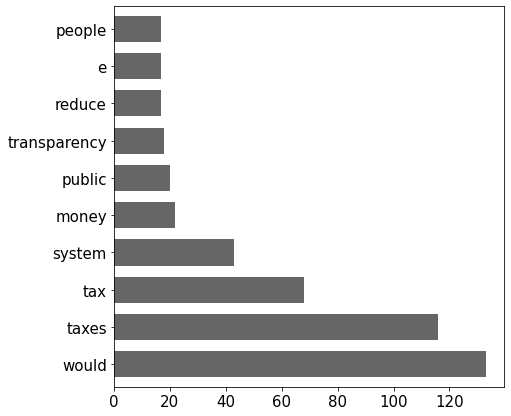

In [27]:
df[f'{TEXT_COLUMN} Tokens'].explode().value_counts()[:10].plot(kind='barh', figsize=(7, 7), color='#666666', zorder=2, width=0.7, fontsize=15)

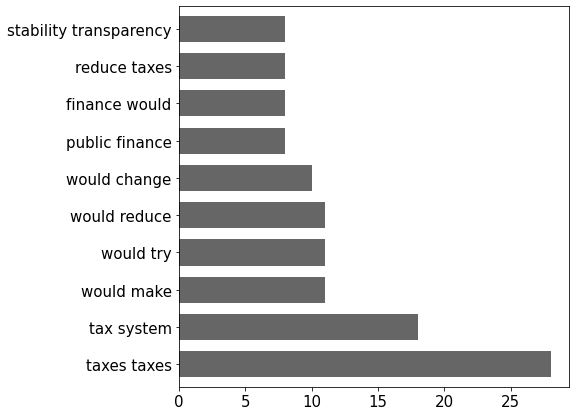

In [28]:
df[f'{TEXT_COLUMN} Bigrams'].explode().value_counts()[:10].plot(kind='barh', figsize=(7, 7), color='#666666', zorder=2, width=0.7, fontsize=15)

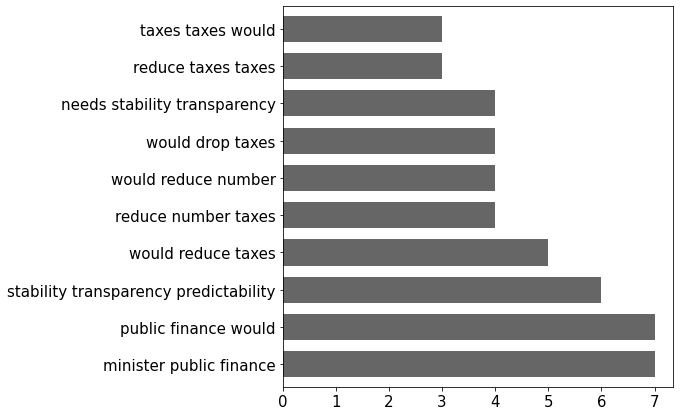

In [29]:
df[f'{TEXT_COLUMN} Trigrams'].explode().value_counts()[:10].plot(kind='barh', figsize=(7, 7), color='#666666', zorder=2, width=0.7, fontsize=15)

Text(0.5, 1.0, '20 Most Frequently Occuring Bigrams')

Text(0, 0.5, 'Bigram')

Text(0.5, 0, 'Frequency')

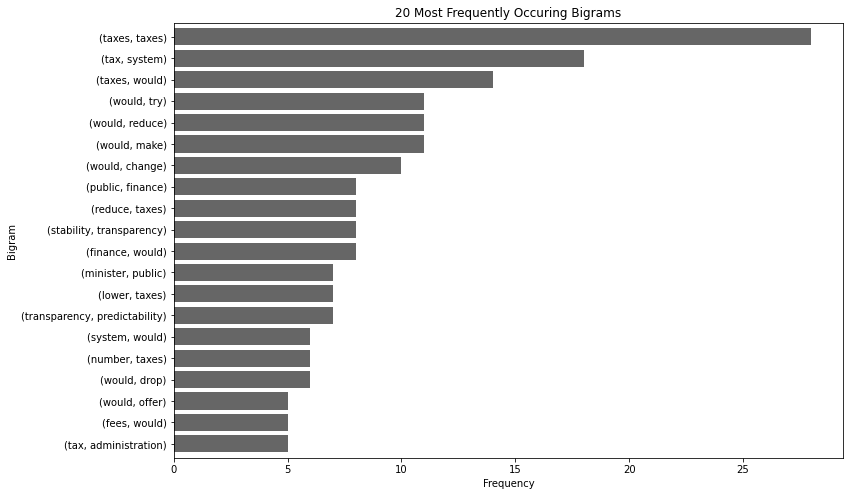

In [30]:
# Most frequent bi-grams and tri-grams
words = df[f'{TEXT_COLUMN} Tokens'].to_list()
words_l = [item for sublist in words for item in sublist]
bigrams_series = (pd.Series(nltk.ngrams(words_l, 2)).value_counts())[:20]

bigrams_series.sort_values().plot.barh(color='#666666', width=.8, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')


Text(0.5, 1.0, '20 Most Frequently Occuring Bigrams')

Text(0, 0.5, 'Trigram')

Text(0.5, 0, 'Frequency')

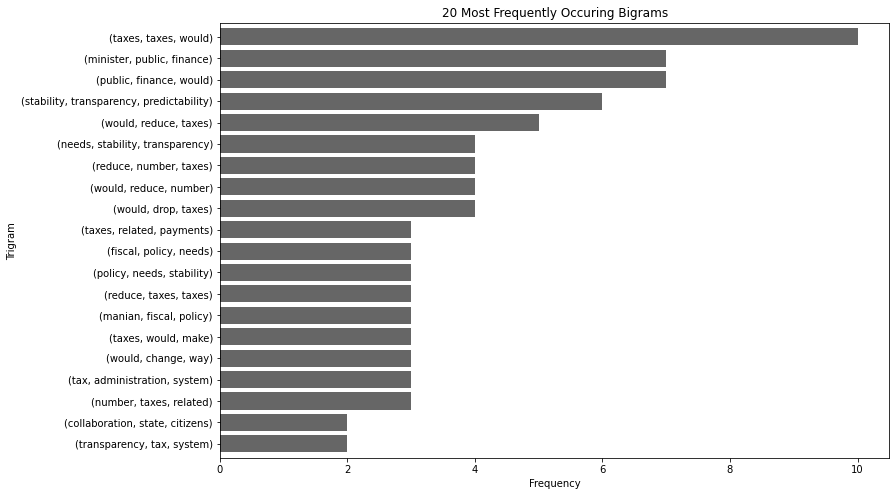

In [31]:
trigrams_series = (pd.Series(nltk.ngrams(words_l, 3)).value_counts())[:20]

trigrams_series.sort_values().plot.barh(color='#666666', width=.8, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')

In [33]:
random_answer = df[TEXT_COLUMN][random.randrange(df.shape[0])]
print('Random answer:', random_answer, '\n')
print('Text Blob score:', TextBlob(random_answer).sentiment.polarity) # scale is -1 to 1
print('Vader score:',SentimentIntensityAnalyzer().polarity_scores(random_answer)['compound']) # Normally works good for social media, scale is -1 to 1
print('Text Afinn score:',Afinn().score(random_answer)) # scale is -5 to 5

Random answer: Taxation of churches lol 

Text Blob score: 0.8
Vader score: 0.4215
Text Afinn score: 3.0


Apply semtiment analysis models to compute sentiment polarity for the text column

In [ ]:
df[f'Sentiment {TEXT_COLUMN}'] = df[TEXT_COLUMN].apply(lambda x: TextBlob(x).sentiment.polarity)
df = df.head(366)

In [ ]:
scaler = preprocessing.MinMaxScaler()
normalized_data = scaler.fit_transform(df[df.iloc[: , :-3]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.iloc[: , :-3]].columns)

In [ ]:
normalized_df.describe()

In [ ]:
# df.to_csv(os.path.join(path, 'data', 'Taxpayer perception on the Fiscal System 367 responses 03.11.2021 with sentiments.csv'), index=False)

<a name="esda"></a>
#2. Exploratory Spatial Data Analysis

Geolocate the data

In [ ]:
df['country_of_residence'].unique()

array(['The Czech Republic', 'Serbia', 'Bosnia and Herzegovina ',
       'Lithuania', 'Italy', 'Romania', 'Turkey', 'Poland', 'France',
       'france ', 'FRANCE', 'France ', 'Switzerland', 'China', 'france',
       'United Kingdom', 'Germany', 'Estonia', 'Netherlands', 'Slovakia',
       'Kingdom of Saudi Arabia', 'Spain', 'Armenia', 'Norway',
       'Portugal', 'Austria', 'Portugal ', 'Turkmenistan'], dtype=object)

In [ ]:
df['country_of_residence'] = df['country_of_residence'].apply(lambda x: x.title().strip())
df['country_of_residence'].unique()

array(['The Czech Republic', 'Serbia', 'Bosnia And Herzegovina',
       'Lithuania', 'Italy', 'Romania', 'Turkey', 'Poland', 'France',
       'Switzerland', 'China', 'United Kingdom', 'Germany', 'Estonia',
       'Netherlands', 'Slovakia', 'Kingdom Of Saudi Arabia', 'Spain',
       'Armenia', 'Norway', 'Portugal', 'Austria', 'Turkmenistan'],
      dtype=object)

In [ ]:
len(df['country_of_residence'].unique()) # 23 countries for which we have answers

23

In [ ]:
eu_nuts = gpd.read_file(os.path.join(path, 'data', 'shapefiles', 'NUTS_RG_20M_2021_3035.shp'))

eu_countries = eu_nuts.dissolve(by='CNTR_CODE')
eu_countries.drop(columns=['NUTS_ID', 'LEVL_CODE', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'FID'], inplace=True)
eu_countries.rename(columns={'CNTR_CODE':'country_code'},inplace=True)
eu_countries.reset_index(inplace=True)
eu_countries.shape
eu_countries.head(2)
eu_countries.plot()

(37, 2)

,CNTR_CODE,geometry
0,AL,"POLYGON ((5205929.468 1908629.067, 5200528.618..."
1,AT,"POLYGON ((4527096.498 2619689.619, 4510728.830..."


In [ ]:
country_codes = pd.read_csv(os.path.join(path, 'data', 'country_codes_europe.csv'))
country_codes = country_codes[['country', 'country_code']]
country_codes.rename(columns={'country': 'country_of_residence'}, inplace=True)
country_codes.shape
country_codes.head()

(52, 2)

,country_of_residence,country_code
0,Austria,AT
1,Belgium,BE
2,Bulgaria,BG
3,Croatia,HR
4,Cyprus,CY


In [ ]:
df['country_of_residence'].replace(to_replace='The Czech Republic', value='Czech Republic', inplace=True)
df['country_of_residence'].replace(to_replace='Bosnia And Herzegovina', value='Bosnia and Herzegovina', inplace=True)
df['country_of_residence'].unique()

array(['Czech Republic', 'Serbia', 'Bosnia and Herzegovina', 'Lithuania',
       'Italy', 'Romania', 'Turkey', 'Poland', 'France', 'Switzerland',
       'China', 'United Kingdom', 'Germany', 'Estonia', 'Netherlands',
       'Slovakia', 'Kingdom Of Saudi Arabia', 'Spain', 'Armenia',
       'Norway', 'Portugal', 'Austria', 'Turkmenistan'], dtype=object)

In [ ]:
df_with_country_codes = df.merge(country_codes, on='country_of_residence', how='inner')
df_with_country_codes.shape

(363, 35)

In [ ]:
gdf_with_country_codes = eu_countries.merge(df_with_country_codes, on='country_code')
gdf_with_country_codes.shape

(361, 36)

In [ ]:
# sns.scatterplot(data=gdf_with_country_codes, x="How do you evaluate your level of trust in the Tax System?", y="Confidence in EU institutions", alpha=0.2, s=70, legend= True)

In [ ]:
# sns.scatterplot(data=gdf_with_country_codes, x="Sentiment If you were the Minister of Public Finance, what would you change about the Tax System?", y="Confidence in EU institutions", alpha=0.2, s=70, legend= True)

In [ ]:
def univariate_autocorrelation(dataset, y_name, w):
  y = dataset[y_name].values

  # GLOBAL SPATIAL AUTOCORRELATION
  print('UNIVARIATE SPATIAL AUTOCORRELATION')
  moran = Moran(y, w, permutations=99999)
  print('Univariate Global Moran I index:', moran.I, '\n p-value:', moran.p_sim) # get global Moran I index and simulated p value
  plot_moran(moran, zstandard=True, figsize=(10,4)); # plot global Moran I statistics result

  # LOCAL SPATIAL AUTOCORRELATION
  moran_loc = Moran_Local(y, w, permutations=9999);
  plot_local_autocorrelation(moran_loc, dataset, y_name, figsize=(30,10));

In [ ]:
w_q = Queen.from_dataframe(gdf_with_country_codes)

UNIVARIATE SPATIAL AUTOCORRELATION
Univariate Global Moran I index: -0.007642139479870617 
 p-value: 0.3408


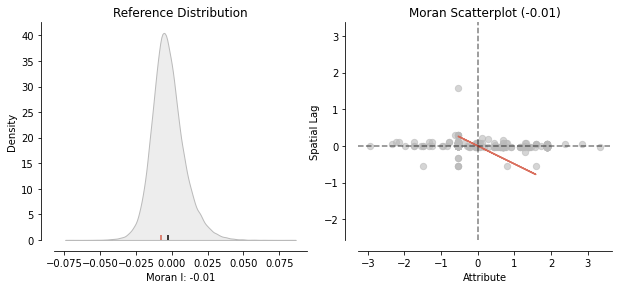

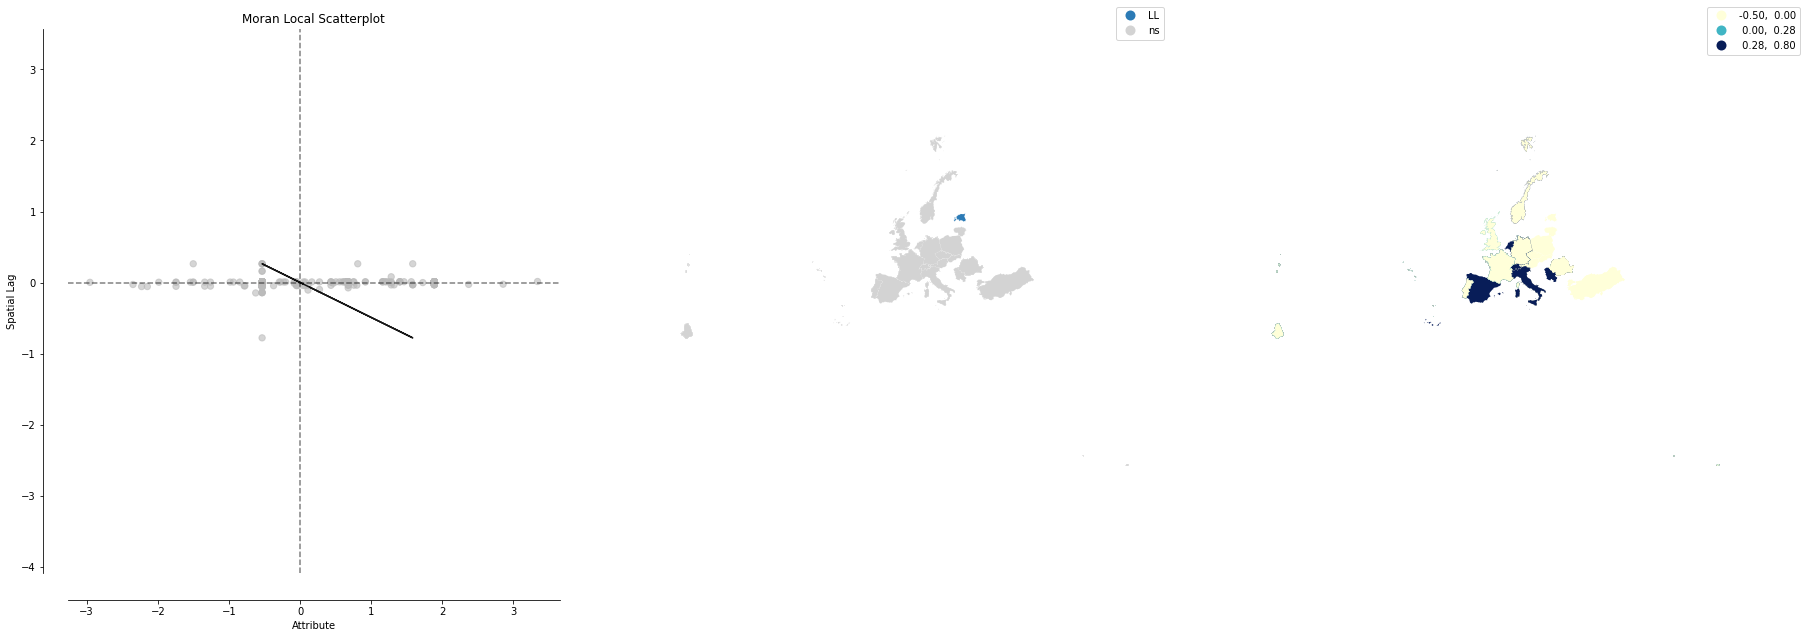

In [ ]:
univariate_autocorrelation(gdf_with_country_codes, 'Sentiment If you were the Minister of Public Finance, what would you change about the Tax System?', w_q)

UNIVARIATE SPATIAL AUTOCORRELATION
('WARNING: ', 13, ' is an island (no neighbors)')
Univariate Global Moran I index: 0.01555429733057305 
 p-value: 0.0588


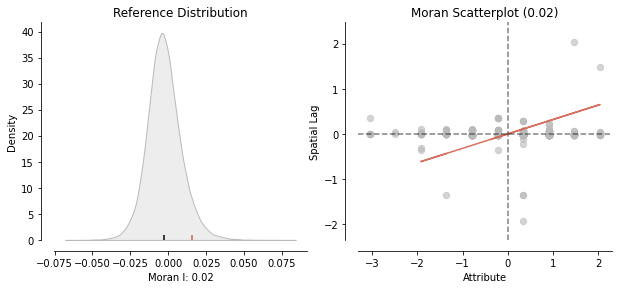

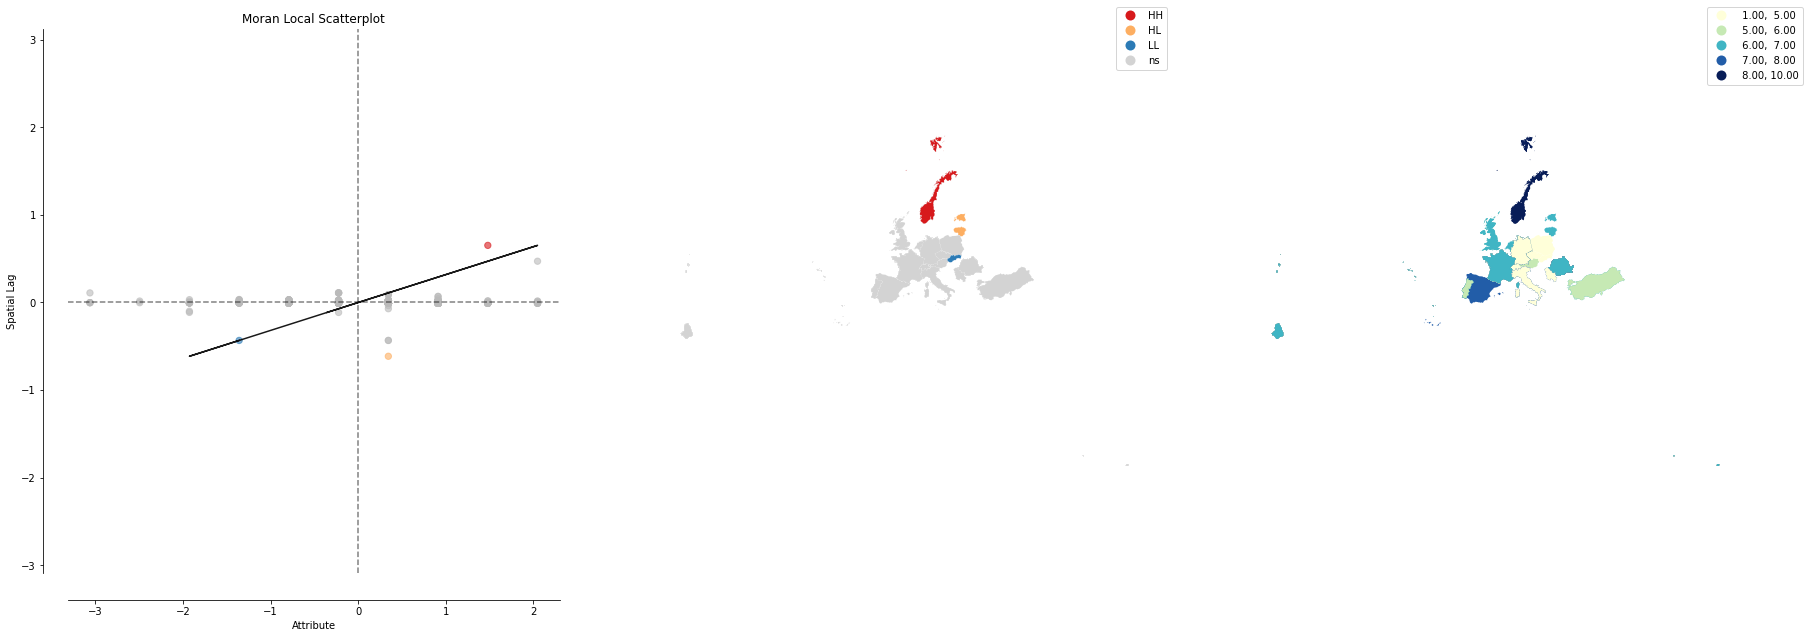

In [ ]:
univariate_autocorrelation(gdf_with_country_codes, 'How do you evaluate your level of trust in the Tax System?', w_q)

UNIVARIATE SPATIAL AUTOCORRELATION
Univariate Global Moran I index: 0.8072568927059348 
 p-value: 1e-05


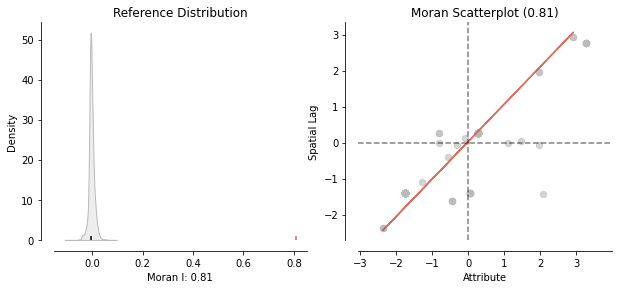

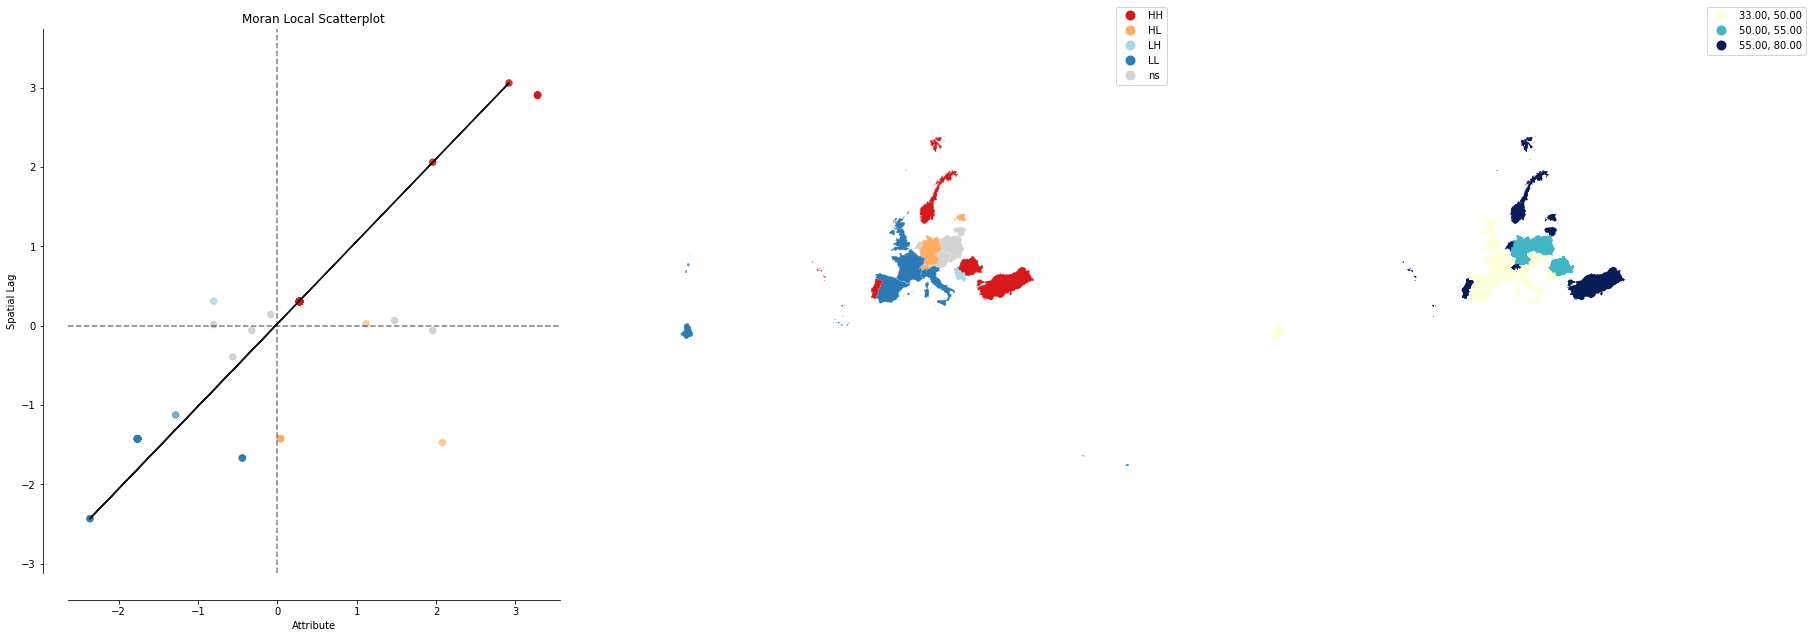

In [ ]:
univariate_autocorrelation(gdf_with_country_codes, 'Confidence in EU institutions', w_q)

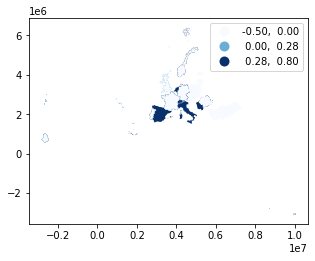

In [ ]:
plt = gdf_with_country_codes.plot(column=gdf_with_country_codes['Sentiment If you were the Minister of Public Finance, what would you change about the Tax System?'], scheme='Quantiles', k=5, cmap='Blues',  legend=True)

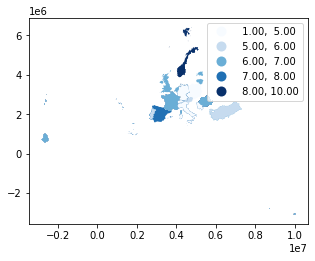

In [ ]:
plt = gdf_with_country_codes.plot(column=gdf_with_country_codes['How do you evaluate your level of trust in the Tax System?'], scheme='Quantiles', k=5, cmap='Blues',  legend=True)

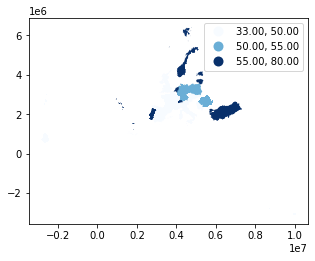

In [ ]:
plt = gdf_with_country_codes.plot(column=gdf_with_country_codes['Confidence in EU institutions'], scheme='Quantiles', k=5, cmap='Blues',  legend=True)

<a name="smss"></a>
# 3. Spatial model specification search
for the assessment of interdependencies, factors, and spatial influences between the attitude towards national institutions and the UN sustainability measures

In [ ]:
gdf_with_country_codes.plot(column='')

In [ ]:
eu_countries['country_code'].unique()

array(['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
       'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU',
       'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE',
       'SI', 'SK', 'TR', 'UK'], dtype=object)

In [ ]:
df_with_country_codes['country_code'].unique()

array(['CZ', 'RS', 'BA', 'LT', 'IT', 'RO', 'TR', 'PL', 'FR', 'CH', 'GB',
       'DE', 'EE', 'NL', 'SK', 'ES', 'AM', 'NO', 'PT', 'AT'], dtype=object)

In [ ]:
[code for code in df_with_country_codes['country_code'].unique() if code not in eu_countries['country_code'].unique()]

['BA', 'GB', 'AM']

In [ ]:
eu_countries_with_names = eu_countries.merge(country_codes, on='country_code')
eu_countries_with_names.shape
eu_countries_with_names.head(2)

(0, 4)

,country_code,geometry,AREA,country_of_residence


<a name="imr"></a>
#4. Interpreting the model’s results
for two distinct trust measures: the score given in the questionnaire and the sentiment computed on top of the open-ended questions on people’s opinion on the fiscal measures. The first will be interpreted as a robustness check for the attitude towards national institutions against the UN SDG goals as proxied by the sustainability measures